In [7]:
import timeit
import pandas as pd
import os
import numpy as np

In [8]:
movies_file = 'data/ml-10M100K/movies.dat'
ratings_file = 'data/ml-10M100K/ratings.dat'


# set static variables
_pickle_dir = os.path.join(os.path.dirname(
    os.path.abspath('eda2.ipynb')), 'data\pickled')

# set appropriate paths for pickle files
_ratings_pickle_filename = 'movie_ratings.pkl'
ratings_pickle_path = os.path.join(_pickle_dir, _ratings_pickle_filename)
_movies_pickle_filename = 'movies.pkl'
movies_pickle_path = os.path.join(_pickle_dir, _movies_pickle_filename)

# try to load from pickle if available
try:
    # load movies df from pickle if it exists
    if os.path.exists(movies_pickle_path+"1"):
        movies_df = pd.read_pickle(movies_pickle_path+"1")
    else :
        movies_df = pd.read_csv(movies_file, engine='python', encoding='utf-8',
                                        sep='::', header=None, names=['movie_id', 'name', 'genres'],
                                        dtype={'movie_id': np.int32, 'name': np.chararray, 'genres': np.chararray})

    # load ratings df from pickle if it exists
    if os.path.exists(ratings_pickle_path+"1"):
        ratings_df = pd.read_pickle(ratings_pickle_path+"1")
    else:
        ratings_df = pd.read_csv(ratings_file, engine='python', encoding='utf-8',
                                        sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'],
                                        dtype={'user_id': np.int32, 'movie_id': np.int32, 'rating': np.int32, 'timestamp': np.float64})
# catch exceptions
except Exception as e:
    print(e)


   movie_id              name                                       genres  \
0         1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1         1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2         1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3         1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4         1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   year  user_id  rating     timestamp  
0  1995        5       1  8.579113e+08  
1  1995       14       3  1.133572e+09  
2  1995       18       3  1.111546e+09  
3  1995       23       5  8.495435e+08  
4  1995       24       5  8.682542e+08  


Text(0, 0.5, 'Frequency')

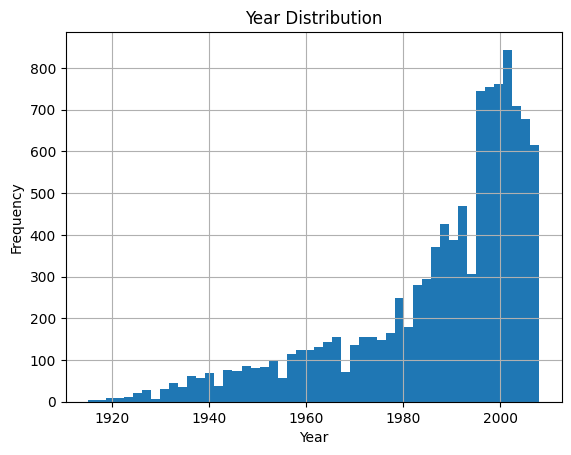

In [9]:
import re
import matplotlib.pyplot as plt

def extract_year(name):
    pattern = r'\((\d{4})\)'
    match = re.search(pattern, name)
    if match:
        return int(match.group(1))
    else:
        return None

movies_df['year'] = movies_df['name'].apply(extract_year)
stats_df = pd.merge(movies_df, ratings_df, how='inner', on='movie_id')
print(stats_df.head())

years = movies_df['year'].values

pd.Series(years).hist(bins=50)

# set the plot title and axis labels
plt.title('Year Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')

# show the plot
# plt.show()


In [10]:
# drop indexes from movies_df
# movies_df.reset_index(inplace=True)
# ratings_df.reset_index(inplace=True)

# merge dataframes using inner join
merged_df = pd.merge(ratings_df, movies_df, how="inner", on="movie_id")
merged_df.head()

# make a set of movie_id where movie has Children genre
# children_movie_ids = set(merged_df.loc[merged_df['genres'].str.contains('Children', na=False), 'movie_id'])
# print(children_movie_ids)

# drop unnecessary columns for performance
merged_df.drop(['timestamp', 'genres'], axis=1, inplace=True)

merged_df = merged_df.groupby(
    by=['movie_id', 'user_id'], as_index=False).agg({"rating": "mean"})

merged_df = merged_df.pivot(index='movie_id', columns='user_id', values='rating').fillna(0)

print(merged_df.shape)


(10677, 69878)


In [59]:
existing_df = pd.read_json('recs-app/public/top_rated_similars_1000.json')
print(existing_df['movie_id'].values[:10])
print(merged_df.loc[296])
print(existing_df.columns)
existing_df['similar_movie_ids'] = [[]] * len(existing_df)


[296 356 593 480 318 110 457 589 260 150]
user_id
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
71563    0.0
71564    0.0
71565    0.0
71566    5.0
71567    0.0
Name: 296, Length: 69878, dtype: float64
Index(['substituted_name', 'description', 'avg_rating', 'num_ratings', 'name',
       'genres', 'movie_id', 'ranking', 'similar_movie_ids'],
      dtype='object')


In [63]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

sparse_item_df = csr_matrix(merged_df.values)
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(sparse_item_df)

# print(merged_df.iloc[296])

for i in existing_df['movie_id'].values:
    weights, neighbors = model.kneighbors([merged_df.loc[i]], n_neighbors=50)
    neighbors = neighbors[0]  
    print(neighbors[:5])
    similar_movie_ids = list(merged_df.iloc[neighbors[1:4]].index)
    existing_df.at[existing_df[existing_df['movie_id'] == i].index[0], 'similar_movie_ids'] = similar_movie_ids

    for idx, n in enumerate(neighbors[1:4]):
        print(movies_df.loc[movies_df['movie_id'] == i]['name'].values[0],movies_df.loc[movies_df['movie_id'] == merged_df.index[n]]['name'].values[0])


[293 587 315  49  46]
Pulp Fiction (1994) Silence of the Lambs, The (1991)
Pulp Fiction (1994) Shawshank Redemption, The (1994)
Pulp Fiction (1994) Usual Suspects, The (1995)
[352 476 453 587 148]
Forrest Gump (1994) Jurassic Park (1993)
Forrest Gump (1994) Fugitive, The (1993)
Forrest Gump (1994) Silence of the Lambs, The (1991)
[587 293 315 453 352]
Silence of the Lambs, The (1991) Pulp Fiction (1994)
Silence of the Lambs, The (1991) Shawshank Redemption, The (1994)
Silence of the Lambs, The (1991) Fugitive, The (1993)
[476 583 352 373 453]
Jurassic Park (1993) Terminator 2: Judgment Day (1991)
Jurassic Park (1993) Forrest Gump (1994)
Jurassic Park (1993) Speed (1994)
[315 293 587 352 148]
Shawshank Redemption, The (1994) Pulp Fiction (1994)
Shawshank Redemption, The (1994) Silence of the Lambs, The (1991)
Shawshank Redemption, The (1994) Forrest Gump (1994)
[108 352 453 476 583]
Braveheart (1995) Forrest Gump (1994)
Braveheart (1995) Fugitive, The (1993)
Braveheart (1995) Jurassic P

KeyError: nan

In [65]:
existing_df.head()
existing_df.to_json('data/top_rated_similars_1000.json', orient='index')